# Importing Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
from sklearn.decomposition import PCA

# Importing Dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# No Missing Values

In [4]:
df.isna().any().any()

False

# Encoding Categorical Values

In [5]:
#Columns with string values
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [6]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42,replacement=True)
X_, Y1 = rus.fit_resample(X,y)
X1 = pd.DataFrame(X_,columns=X.columns)

ros = RandomOverSampler(random_state=42)
X_, Y2 = ros.fit_resample(X,y)
X2 = pd.DataFrame(X_,columns=X.columns)

# UnderSampling

In [8]:
X=X1
y=Y1

# Spliting into Train and Test Sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

## PCA

Two PCs explain [ 70.74068688  99.76281581  99.9990502   99.99964764  99.99976362
  99.99985316  99.99991339  99.99993267  99.9999509   99.99995939
  99.99996725  99.99997381  99.99997993  99.99998388  99.99998674
  99.99998908  99.9999908   99.99999245  99.99999402  99.99999552
  99.99999682  99.99999756  99.9999982   99.99999876  99.9999991
  99.99999939  99.99999963  99.99999983  99.99999994 100.        ] % of variance cumulatively


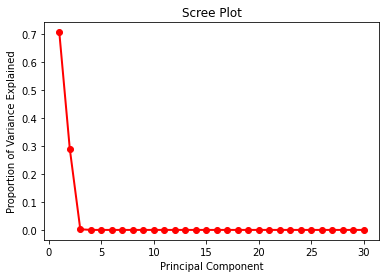

In [10]:
pca = PCA(random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

Two PCs explain [70.74068688 99.76281581] % of variance cumulatively


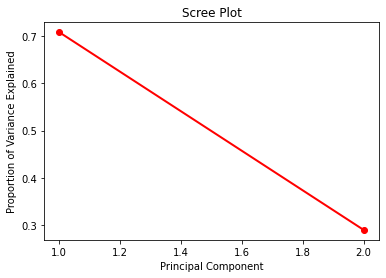

In [11]:
pca = PCA(n_components=2, random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [12]:
X_train = principalComponents
X_test = pca.transform(X_test)

# Applying Random Forest

In [13]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
# Setting random state for randomization
rf = RandomForestClassifier(random_state=42)


# Hyperparameter Tuning

Randomized Search Cross Validation

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Taking a huge range of values to get nearer to optimal parameters

# Parameters to check
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 150, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [16]:
# Using the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)


In [17]:
# Training model and printing results
train_predict_evaluate (rf_random, X_train, y_train, X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy:  0.6153846153846154
Precision:  0.6666666666666666
Recall:  0.5333333333333333
Confusion Matrix:
 [[48 20]
 [35 40]]


In [18]:
# Finding the best parameters
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 100}

Grid Search Cross Validation

In [19]:
from sklearn.model_selection import GridSearchCV

# After getting near to optimal values, using Random Search CV, 
# we now check for close values using Grid Search CV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100, 105, 110, 115],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'n_estimators': [250,300,350,400]
}

In [20]:
# Grid Search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Results on the Grid Search model
train_predict_evaluate (grid_search, X_train, y_train, X_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Accuracy:  0.6153846153846154
Precision:  0.6666666666666666
Recall:  0.5333333333333333
Confusion Matrix:
 [[48 20]
 [35 40]]


In [21]:
# Finding the best parameters
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 250}

In [22]:
# Hyperparameter Tuning done
# Best parameters found above
# Using these parameters on our Random Forest model for most optimal results
best_rf = RandomForestClassifier(bootstrap=False, max_depth=100, 
                                 min_samples_leaf=1,min_samples_split=2, 
                                 n_estimators=250, random_state=42)
train_predict_evaluate (best_rf, X_train, y_train, X_test)

Accuracy:  0.6223776223776224
Precision:  0.6721311475409836
Recall:  0.5466666666666666
Confusion Matrix:
 [[48 20]
 [34 41]]


# K-Fold Cross Validation

In [23]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  print("Accuracy: ", np.mean(scores['test_accuracy']))
  print("Precision: ", np.mean(scores['test_precision']))
  print("Recall: ", np.mean(scores['test_recall']))
  print("F1 Score: ", np.mean(scores['test_f1']))


Performing K-Fold Cross Validation on our model

In [24]:
# On model without Hyperparameter Tuning
cross_validation(rf, X, y)

Accuracy:  0.7510414333706608
Precision:  0.7589733543741272
Recall:  0.7388297872340426
F1 Score:  0.7473650969091697


In [25]:
# On model with Hyperparameter Tuning
cross_validation(best_rf, X, y)

Accuracy:  0.7236058230683091
Precision:  0.7262550395097565
Recall:  0.7261524822695036
F1 Score:  0.7239686165560528


# Oversampling


In [26]:
X=X2
y=Y2

# Spliting into Train and Test Sets

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

## PCA

Two PCs explain [ 72.0048171   99.77248109  99.99907351  99.99964762  99.99976043
  99.99985629  99.99991542  99.99993416  99.99995029  99.99995944
  99.99996697  99.99997386  99.99997952  99.99998392  99.99998664
  99.99998883  99.99999061  99.99999228  99.99999387  99.99999531
  99.99999661  99.9999974   99.99999814  99.9999987   99.99999903
  99.99999934  99.99999961  99.99999981  99.99999993 100.        ] % of variance cumulatively


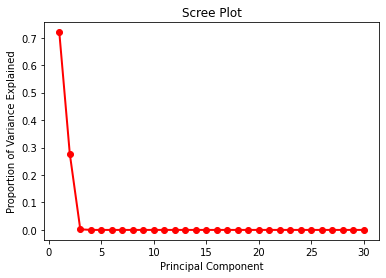

In [28]:
pca = PCA(random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

Two PCs explain [72.0048171  99.77248109] % of variance cumulatively


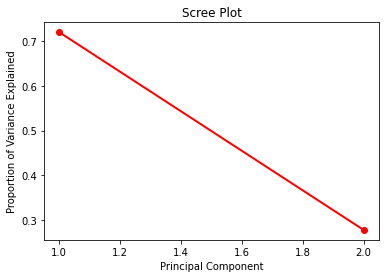

In [29]:
pca = PCA(n_components=2, random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [30]:
X_train = principalComponents
X_test = pca.transform(X_test)

# Applying Random Forest

In [31]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
# Setting random state for randomization
rf = RandomForestClassifier(random_state=42)


# Hyperparameter Tuning

Randomized Search Cross Validation

In [33]:
from sklearn.model_selection import RandomizedSearchCV

# Taking a huge range of values to get nearer to optimal parameters

# Parameters to check
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 150, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [34]:
# Using the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)


In [35]:
# Training model and printing results
train_predict_evaluate (rf_random, X_train, y_train, X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy:  0.9351351351351351
Precision:  0.9061032863849765
Recall:  0.9796954314720813
Confusion Matrix:
 [[306  40]
 [  8 386]]


In [36]:
# Finding the best parameters
rf_random.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000}

Grid Search Cross Validation

In [37]:
from sklearn.model_selection import GridSearchCV

# After getting near to optimal values, using Random Search CV, 
# we now check for close values using Grid Search CV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100, 105, 110, 115],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'n_estimators': [250,300,350,400]
}

In [38]:
# Grid Search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Results on the Grid Search model
train_predict_evaluate (grid_search, X_train, y_train, X_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Accuracy:  0.9297297297297298
Precision:  0.8976744186046511
Recall:  0.9796954314720813
Confusion Matrix:
 [[302  44]
 [  8 386]]


In [39]:
# Finding the best parameters
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [40]:
# Hyperparameter Tuning done
# Best parameters found above
# Using these parameters on our Random Forest model for most optimal results
best_rf = RandomForestClassifier(bootstrap=False, max_depth=100, 
                                 min_samples_leaf=1,min_samples_split=2, 
                                 n_estimators=250, random_state=42)
train_predict_evaluate (best_rf, X_train, y_train, X_test)

Accuracy:  0.9310810810810811
Precision:  0.8997668997668997
Recall:  0.9796954314720813
Confusion Matrix:
 [[303  43]
 [  8 386]]


# K-Fold Cross Validation

In [41]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  print("Accuracy: ", np.mean(scores['test_accuracy']))
  print("Precision: ", np.mean(scores['test_precision']))
  print("Recall: ", np.mean(scores['test_recall']))
  print("F1 Score: ", np.mean(scores['test_f1']))


Performing K-Fold Cross Validation on our model

In [42]:
# On model without Hyperparameter Tuning
cross_validation(rf, X, y)

Accuracy:  0.9760764057123618
Precision:  0.9565186465220676
Recall:  0.9975708502024292
F1 Score:  0.9765936592741291


In [43]:
# On model with Hyperparameter Tuning
cross_validation(best_rf, X, y)

Accuracy:  0.9914848362910709
Precision:  0.9856088402213505
Recall:  0.9975708502024292
F1 Score:  0.9915361442773062
